In [ ]:
import numpy as np
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/matala2_cosmetics_2019-Nov.csv')

1.

In [ ]:
def duration_of_event(df):
  df['event_time'] = df['event_time'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S UTC'))
  df = df.sort_values(['user_id', 'user_session', 'event_time'])
  df['next_event_time'] = df.groupby(['user_id', 'user_session'])['event_time'].shift(-1)
  df['duration_to_next_event'] = (df['next_event_time'] - df['event_time']).dt.total_seconds()
  df['duration_to_next_event'] = df['duration_to_next_event'].fillna(0)
  df = df.drop('next_event_time', axis=1)
  return df

# check
df = duration_of_event(df)
df[df['user_session']=='670cb8b4-bef1-4ec7-bfe8-7c8317967c74']

2.

In [ ]:
def num_of_event(df):
  df = df.sort_values(['user_id', 'event_time'])
  df['time_diff'] = df.groupby('user_id')['event_time'].diff()
  df['time_diff'] = df['time_diff'].apply(lambda x: x.days)
  df['new_panel'] = (df['time_diff'] > 5) | (df['time_diff'].isnull())
  df['funnel_number'] = df.groupby('user_id')['new_panel'].cumsum()
  df = df.drop(['time_diff', 'new_panel'], axis=1)
  return df

df = num_of_event(df)
df

3.

In [ ]:
def index_in_funnel(df):
  df['index_in_funnel'] = df.groupby(['user_id', 'funnel_number'])['user_session'].transform(lambda x: pd.factorize(x)[0]+1)
  return df

df = index_in_funnel(df)
df

4.

In [8]:
def re_price(price):
    if isinstance(price, str):
        match = re.search(r'\d+\.?\d*', price)
        if match:
            return float(match.group())
    elif isinstance(price, float):
        return price
    return None

df['price'] = df['price'].apply(re_price)

5.

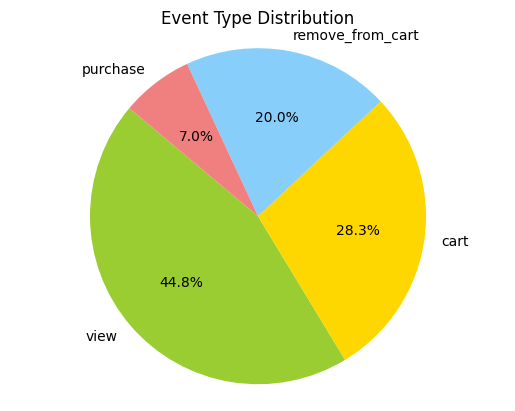

In [9]:
event_counts = df['event_type'].value_counts()

labels = event_counts.index
sizes = event_counts.values
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Event Type Distribution')

plt.axis('equal')
plt.show()

6.

In [ ]:
def session_sum_up(df):
    grouped = df.groupby(['user_session'])

    aggregations = {
        'duration_to_next_event': 'sum',
        'event_type': lambda x: list(x),
        'user_id': 'first',
        'funnel_number': 'first',
        'index_in_funnel': 'first',
        'product_id': lambda x: list(x),
        'category_code': lambda x: len(x),
        'product_id': lambda x: list(x)
    }

    session_summary = grouped.agg(aggregations).reset_index()
    session_summary = session_summary.rename(columns={'category_code': 'num_events'})
    session_summary = session_summary.rename(columns={'duration_to_next_event': 'session_duration'})

    session_summary['list_of_viewed'] = session_summary.apply(lambda x: [i for i, j in zip(x['product_id'], x['event_type']) if j == 'view'], axis=1)
    session_summary['list_of_added_to_cart'] = session_summary.apply(lambda x: [i for i, j in zip(x['product_id'], x['event_type']) if j == 'cart'], axis=1)
    session_summary['list_of_purchased'] = session_summary.apply(lambda x: [i for i, j in zip(x['product_id'], x['event_type']) if j == 'purchase'], axis=1)

    session_summary = session_summary.drop(['product_id', 'event_type'], axis=1)
    
    return session_summary
  
session_data  = session_sum_up(df)
session_data .head()
     
